# Telkom Stock Prediction

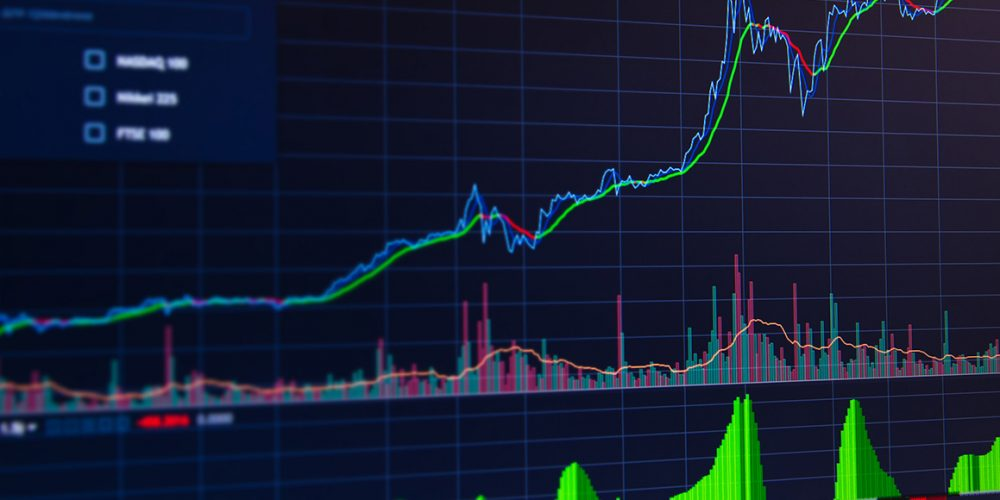

## Libraries

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

from keras.layers import GRU, Dropout, Dense, Conv1D, MaxPooling1D, Flatten, LSTM, Input, Bidirectional, BatchNormalization, Concatenate, Layer, Activation, Permute, Multiply, Lambda, Dot
from keras.models import Sequential

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Input

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr

# yf.pdr_override()

# from scikeras.wrappers import KerasRegressor
# from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit, train_test_split, GridSearchCV
from keras_tuner import HyperModel, RandomSearch

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Attention
from tensorflow.keras.optimizers import Adam, SGD
from scikeras.wrappers import KerasRegressor, KerasClassifier

# For time stamps
from datetime import datetime, timedelta

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import torch
from torch.utils.data import DataLoader
# from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
# from pytorch_forecasting.data import NaNLabelEncoder
# from pytorch_forecasting.metrics import QuantileLoss
# import matplotlib.pyplot as plt

import tensorflow as tf
import random

# Set seed untuk random number generator di Python
random.seed(42)

# Set seed untuk NumPy
np.random.seed(42)

# Set seed untuk TensorFlow
tf.random.set_seed(42)

from tensorflow.keras import backend as K

In [4]:
# df = pd.read_csv('telkom_with_sentiment2.csv')
# df = pd.read_csv('bca_with_sentiment3.csv')
# df = pd.read_csv('astra_with_sentiment3.csv')
df = pd.read_csv('mandiri_with_sentiment.csv')

## Pre-process

In [6]:
def convert_date(date_string):
  return datetime.strptime(date_string, "%Y-%m-%d")  # Adjust format if needed

df['Date'] = df['Date'].apply(convert_date)  # Replace 'date_column' with your actual column name
correlation_matrix = df.corr()
target_correlation = correlation_matrix['Close'].sort_values(ascending=False)
print(target_correlation)

Close            1.000000
High             0.910465
Low              0.879557
SMA3             0.783113
Open             0.754027
SMA1             0.661328
SMA2             0.556497
MACD             0.391479
Date             0.388576
ROA              0.388576
EPS              0.388576
RSI              0.125064
Sentiment        0.031175
Volume          -0.144541
Current Ratio   -0.388576
Name: Close, dtype: float64


In [7]:
# # Dataframe awal (gunakan dataset Anda sendiri)
# data = df

# # Fitur teknikal, fundamental, dan sentimen
# # technical_features = ['Close']
# technical_features = ['Close', 'Volume', 'Open', 'High', 'Low', 'MACD', 'RSI', 'SMA1', 'SMA2', 'SMA3']
# # fundamental_features = ['Volume', 'Open', 'High', 'Low', 'MACD', 'RSI', 'SMA1', 'SMA2', 'SMA3']
# fundamental_features = ['EPS', 'ROA', 'Current Ratio']
# sentiment_features = ['Sentiment']

# # Skala data
# scaler_technical = MinMaxScaler()
# scaler_fundamental = MinMaxScaler()
# scaler_sentiment = MinMaxScaler()

# data_technical = scaler_technical.fit_transform(data[technical_features])
# data_fundamental = scaler_fundamental.fit_transform(data[fundamental_features])
# data_sentiment = scaler_sentiment.fit_transform(data[sentiment_features])

# # Fungsi untuk membuat dataset time-series
# def create_dataset(dataset, look_back=10):
#     X, y = [], []
#     for i in range(len(dataset) - look_back):
#         X.append(dataset[i:i + look_back])
#         y.append(dataset[i + look_back, 0])  # Target adalah 'Close'
#     return np.array(X), np.array(y)

# # Buat dataset teknikal
# look_back = 10
# X_technical, y = create_dataset(data_technical, look_back)

# # Buat dataset fundamental
# X_fundamental, _ = create_dataset(data_fundamental, look_back)

# # Buat dataset sentimen
# X_sentiment, _ = create_dataset(data_sentiment, look_back)

# # Pastikan shape sesuai
# print(f"Shape X_technical: {X_technical.shape}, X_fundamental: {X_fundamental.shape}, X_sentiment: {X_sentiment.shape}, y: {y.shape}")

# # Bagi data menjadi train dan test
# X_train_technical, X_test_technical, X_train_fundamental, X_test_fundamental, X_train_sentiment, X_test_sentiment, y_train, y_test = train_test_split(
#     X_technical, X_fundamental, X_sentiment, y, test_size=0.2, random_state=42
# )

In [8]:
data = df
# Konversi kolom 'Date' menjadi datetime
data['Date'] = pd.to_datetime(data['Date'])

# Ambil kolom 'Close' untuk prediksi dan fitur lainnya
technical_features = ['Close', 'Volume', 'Open', 'High', 'Low', 'MACD', 'RSI', 'SMA1', 'SMA2', 'SMA3']
fundamental_features = ['EPS', 'ROA', 'Current Ratio']
sentiment_features = ['Sentiment']

# Skala data
scaler_technical = MinMaxScaler()
scaler_fundamental = MinMaxScaler()
scaler_sentiment = MinMaxScaler()

data_technical = scaler_technical.fit_transform(data[technical_features])
data_fundamental = scaler_fundamental.fit_transform(data[fundamental_features])
data_sentiment = scaler_sentiment.fit_transform(data[sentiment_features])

# Fungsi untuk membuat dataset time-series
def create_dataset(dataset, look_back=10):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back])
        y.append(dataset[i + look_back, 0])  # Target adalah 'Close'
    return np.array(X), np.array(y)

# Buat dataset teknikal
look_back = 1
X_technical, y = create_dataset(data_technical, look_back)

# Buat dataset fundamental
X_fundamental, _ = create_dataset(data_fundamental, look_back)

# Buat dataset sentimen
X_sentiment, _ = create_dataset(data_sentiment, look_back)

# Pastikan shape sesuai
print(f"Shape X_technical: {X_technical.shape}, X_fundamental: {X_fundamental.shape}, X_sentiment: {X_sentiment.shape}, y: {y.shape}")

# Bagi data menjadi train dan test secara manual
train_size = int(len(data) * 0.8)
X_train_technical = X_technical[:train_size]
X_test_technical = X_technical[train_size:]

X_train_fundamental = X_fundamental[:train_size]
X_test_fundamental = X_fundamental[train_size:]

X_train_sentiment = X_sentiment[:train_size]
X_test_sentiment = X_sentiment[train_size:]

y_train = y[:train_size]
y_test = y[train_size:]

Shape X_technical: (39, 1, 10), X_fundamental: (39, 1, 3), X_sentiment: (39, 1, 1), y: (39,)


In [9]:
# # Define the model creation function
# def create_model(learning_rate=0.001):
#     # Technical input and branch
#     input_technical = Input(shape=(look_back, len(technical_features)))
#     x_technical = LSTM(100, return_sequences=True)(input_technical)
#     x_technical = LSTM(32, return_sequences=True)(x_technical)
#     x_technical = LSTM(32, return_sequences=True)(x_technical)
#     x_technical = LSTM(32, return_sequences=True)(x_technical)

#     # Fundamental input and branch
#     input_fundamental = Input(shape=(look_back, len(fundamental_features)))
#     x_fundamental = LSTM(100, return_sequences=True)(input_fundamental)
#     x_fundamental = LSTM(32, return_sequences=True)(x_fundamental)
#     x_fundamental = LSTM(32, return_sequences=True)(x_fundamental)
#     x_fundamental = LSTM(32, return_sequences=True)(x_fundamental)

#     # Sentiment input and branch
#     input_sentiment = Input(shape=(look_back, len(sentiment_features)))
#     x_sentiment = LSTM(100, return_sequences=True)(input_sentiment)
#     x_sentiment = LSTM(32, return_sequences=True)(x_sentiment)
#     x_sentiment = LSTM(32, return_sequences=True)(x_sentiment)
#     x_sentiment = LSTM(32, return_sequences=True)(x_sentiment)

#     # Combine all branches
#     combined = Concatenate()([x_technical, x_fundamental, x_sentiment])

#     # LSTM layers after concatenation
#     x_combined = LSTM(64, return_sequences=True)(combined)
#     x_combined = LSTM(32, return_sequences=False)(x_combined)

#     # Dense layers
#     x = Dense(100, activation='relu')(x_combined)
#     output = Dense(1)(x)

#     # Build model
#     model = Model(inputs=[input_technical, input_fundamental, input_sentiment], outputs=output)
#     optimizer = Adam(learning_rate=learning_rate)
#     model.compile(optimizer=optimizer, loss='mean_squared_error')
#     return model

In [10]:
# # Hyperparameter combinations
# param_grid = {
#     'learning_rate': [0.01, 0.001, 0.0001],
#     'batch_size': [16, 32, 64],
#     'epochs': [10, 50, 100],
# }
# # List to store results
# results = []

# # Iterate over all combinations of hyperparameters
# for lr in param_grid['learning_rate']:
#     for batch_size in param_grid['batch_size']:
#         for epochs in param_grid['epochs']:
#             print(f"Training with learning_rate={lr}, batch_size={batch_size}, epochs={epochs}")
            
#             # Create model
#             model = create_model(learning_rate=lr)
            
#             # Train model
#             history = model.fit(
#                 [X_train_technical, X_train_fundamental, X_train_sentiment], 
#                 y_train,
#                 validation_split=0.1,
#                 epochs=epochs,
#                 batch_size=batch_size,
#                 verbose=0  # Suppress detailed output
#             )
            
#             # Predict on test data
#             y_pred = model.predict([X_test_technical, X_test_fundamental, X_test_sentiment])
            
#             # Inverse transform predictions and actual values
#             y_test_inversed = scaler_technical.inverse_transform(
#                 np.hstack([y_test.reshape(-1, 1), np.zeros((len(y_test), len(technical_features) - 1))])
#             )[:, 0]

#             y_pred_inversed = scaler_technical.inverse_transform(
#                 np.hstack([y_pred, np.zeros((len(y_pred), len(technical_features) - 1))])
#             )[:, 0]

#             # Calculate RMSE
#             rmse = np.sqrt(mean_squared_error(y_test_inversed, y_pred_inversed))
#             print(f"RMSE: {rmse}")
            
#             # Store result
#             results.append({
#                 'learning_rate': lr,
#                 'batch_size': batch_size,
#                 'epochs': epochs,
#                 'rmse': rmse
#             })

In [11]:
# # Convert results to DataFrame for analysis
# results_df = pd.DataFrame(results)

# # Sort by RMSE (ascending order)
# results_df = results_df.sort_values(by='rmse')

# # Display all results
# print("\nAll Results:")
# print(results_df)

# # Display the best combination
# best_result = results_df.iloc[0]
# print(f"\nBest Combination: {best_result.to_dict()}")

In [12]:
# 'tech_units_0': 48, 'tech_units_1': 128, 'tech_units_2': 80, 'tech_units_3': 80, 
# 'fund_units_0': 32, 'fund_units_1': 48, 'fund_units_2': 96, 'fund_units_3': 48, 'sent_units_0': 112, 'sent_units_1': 80, 
# 'sent_units_2': 16, 'sent_units_3': 32, 'combined_units': 80, 'combined_units2': 112

In [13]:
# Technical input and branch
input_technical = Input(shape=(look_back, len(technical_features)))
x_technical = LSTM(64, return_sequences=True)(input_technical)
x_technical = LSTM(32, return_sequences=True)(x_technical)
# x_technical = LSTM(32, return_sequences=True)(x_technical)
# x_technical = LSTM(32, return_sequences=True)(x_technical)
# x_technical = LSTM(32, return_sequences=True)(x_technical)

# Fundamental input and branch
input_fundamental = Input(shape=(look_back, len(fundamental_features)))
x_fundamental = LSTM(64, return_sequences=True)(input_fundamental)
x_fundamental = LSTM(32, return_sequences=True)(x_fundamental)
# x_fundamental = LSTM(32, return_sequences=True)(x_fundamental)
# x_fundamental = LSTM(32, return_sequences=True)(x_fundamental)
# x_fundamental = LSTM(32, return_sequences=True)(x_fundamental)

# Sentiment input and branch
input_sentiment = Input(shape=(look_back, len(sentiment_features)))
x_sentiment = LSTM(64, return_sequences=True)(input_sentiment)
x_sentiment = LSTM(32, return_sequences=True)(x_sentiment)
# x_sentiment = LSTM(32, return_sequences=True)(x_sentiment)
# x_sentiment = LSTM(32, return_sequences=True)(x_sentiment)
# x_sentiment = LSTM(32, return_sequences=True)(x_sentiment)

# Combine all branches
combined = Concatenate()([x_technical, x_fundamental, x_sentiment])

# LSTM layers after concatenation
x_combined = LSTM(64, return_sequences=True)(combined)
x_combined = LSTM(32, return_sequences=False)(x_combined)

# Dense layers
x = Dense(100, activation='relu')(x_combined)
output = Dense(1)(x)

# Build model
model = Model(inputs=[input_technical, input_fundamental, input_sentiment], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 1, 10)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_1 (InputLayer)    │ (None, 1, 3)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_2 (InputLayer)    │ (None, 1, 1)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ (None, 1, 64)             │          19,200 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_2 (LSTM)                 │ (None, 1, 64)             │          17,408 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_4 (LSTM)                 │ (None, 1, 64)             │          16,896 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_1 (LSTM)                 │ (None, 1, 32)             │          12,416 │ lstm[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_3 (LSTM)                 │ (None, 1, 32)             │          12,416 │ lstm_2[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_5 (LSTM)                 │ (None, 1, 32)             │          12,416 │ lstm_4[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 1, 96)             │               0 │ lstm_1[0][0],              │
│                               │                           │                 │ lstm_3[0][0], lstm_5[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_6 (LSTM)                 │ (None, 1, 64)             │          41,216 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_7 (LSTM)                 │ (None, 32)                │          12,416 │ lstm_6[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 100)               │           3,300 │ lstm_7[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 1)                 │             101 │ dense[0][0]                │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 147,785 (577.29 KB)

 Trainable params: 147,785 (577.29 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# # Aman dihapus aja

# # Technical input and branch
# input_technical = Input(shape=(look_back, len(technical_features)))
# x_technical = Bidirectional(GRU(64, return_sequences=True))(input_technical)
# x_technical = Bidirectional(GRU(32, return_sequences=True))(x_technical)
# # x_technical = Bidirectional(GRU(32, return_sequences=True))(x_technical)
# # x_technical = Bidirectional(GRU(32, return_sequences=True))(x_technical)
# # x_technical = Bidirectional(GRU(32, return_sequences=True))(x_technical)

# # Fundamental input and branch
# input_fundamental = Input(shape=(look_back, len(fundamental_features)))
# x_fundamental = Bidirectional(GRU(64, return_sequences=True))(input_fundamental)
# x_fundamental = Bidirectional(GRU(32, return_sequences=True))(x_fundamental)
# # x_fundamental = Bidirectional(GRU(32, return_sequences=True))(x_fundamental)
# # x_fundamental = Bidirectional(GRU(32, return_sequences=True))(x_fundamental)
# # x_fundamental = Bidirectional(GRU(32, return_sequences=True))(x_fundamental)

# # Sentiment input and branch
# input_sentiment = Input(shape=(look_back, len(sentiment_features)))
# x_sentiment = Bidirectional(GRU(64, return_sequences=True))(input_sentiment)
# x_sentiment = Bidirectional(GRU(32, return_sequences=True))(x_sentiment)
# # x_sentiment = Bidirectional(GRU(32, return_sequences=True))(x_sentiment)
# # x_sentiment = Bidirectional(GRU(32, return_sequences=True))(x_sentiment)
# # x_sentiment = Bidirectional(GRU(32, return_sequences=True))(x_sentiment)

# # Combine all branches
# combined = Concatenate()([x_technical, x_fundamental, x_sentiment])

# # # GRU layers after concatenation
# x_combined = Bidirectional(GRU(64, return_sequences=True))(combined)
# x_combined = Bidirectional(GRU(32, return_sequences=False))(x_combined)

# # Dense layers
# x = Dense(100, activation='relu')(x_combined)
# output = Dense(1)(x)

# # Build model
# model = Model(inputs=[input_technical, input_fundamental, input_sentiment], outputs=output)
# model.compile(optimizer='adam', loss='mean_squared_error')

# # Model summary
# model.summary()

In [15]:
# from keras.callbacks import EarlyStopping

# Early stopping callback
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Latih model
history = model.fit(
    [X_train_technical, X_train_fundamental, X_train_sentiment], y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=16,
    verbose=1
)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - loss: 0.2268 - val_loss: 0.1891
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2141 - val_loss: 0.1774
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2007 - val_loss: 0.1653
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1867 - val_loss: 0.1527
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1721 - val_loss: 0.1396
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1567 - val_loss: 0.1261
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1406 - val_loss: 0.1121
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1237 - val_loss: 0.0976
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1059 - val_loss: 0.0828
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0873 - val_loss: 0.0680
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0683 - val_loss: 0.0540
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0497 - val_los

In [16]:
# predicted = model.predict([X_test_technical, X_test_fundamental, X_test_sentiment])

# # Evaluasi tanpa inverse transform
# rmse_no_inverse = np.sqrt(mean_squared_error(y_test, predicted))
# print(f"RMSE tanpa inverse transform: {rmse_no_inverse}")

In [17]:
# Predictions
predicted = model.predict([X_test_technical, X_test_fundamental, X_test_sentiment])

# Inverse transform predictions and targets
y_test_inversed = scaler_technical.inverse_transform(np.hstack((y_test.reshape(-1, 1), np.zeros((len(y_test), len(technical_features) - 1)))))[:, 0]
predicted_inversed = scaler_technical.inverse_transform(np.hstack((predicted, np.zeros((len(predicted), len(technical_features) - 1)))))[:, 0]

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test_inversed, predicted_inversed))
print(f"RMSE: {rmse}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
RMSE: 144.49693525363602


In [18]:
# # Predictions
# predicted = model.predict([X_test_technical, X_test_fundamental, X_test_sentiment])

# # Inverse transform predictions and targets
# y_test_inversed = scaler_technical.inverse_transform(np.hstack((y_test.reshape(-1, 1), np.zeros((len(y_test), len(technical_features) - 1)))))[:, 0]
# predicted_inversed = scaler_technical.inverse_transform(np.hstack((predicted, np.zeros((len(predicted), len(technical_features) - 1)))))[:, 0]

# # Evaluate
# rmse = np.sqrt(mean_squared_error(y_test_inversed, predicted_inversed))
# print(f"RMSE: {rmse}")

Length of dates: 7
Length of y_test_inversed: 7


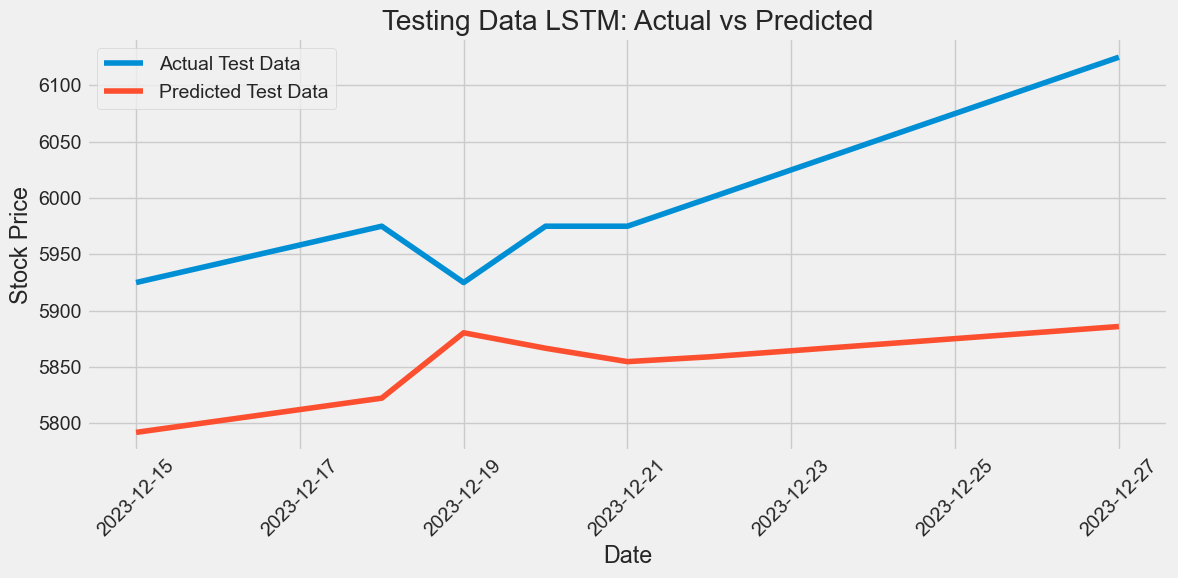

In [19]:
import matplotlib.pyplot as plt

# Pastikan kolom 'Date' sudah menjadi datetime
# dan memiliki jumlah yang sesuai dengan y_test dan predicted
dates = data['Date'][train_size:train_size + len(y_test)]
print(f"Length of dates: {len(dates)}")
print(f"Length of y_test_inversed: {len(y_test_inversed)}")


# Plot hasil prediksi vs data asli untuk testing
plt.figure(figsize=(12, 6))
plt.plot(dates, y_test_inversed, label='Actual Test Data')
plt.plot(dates, predicted_inversed, label='Predicted Test Data')
plt.title('Testing Data LSTM: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

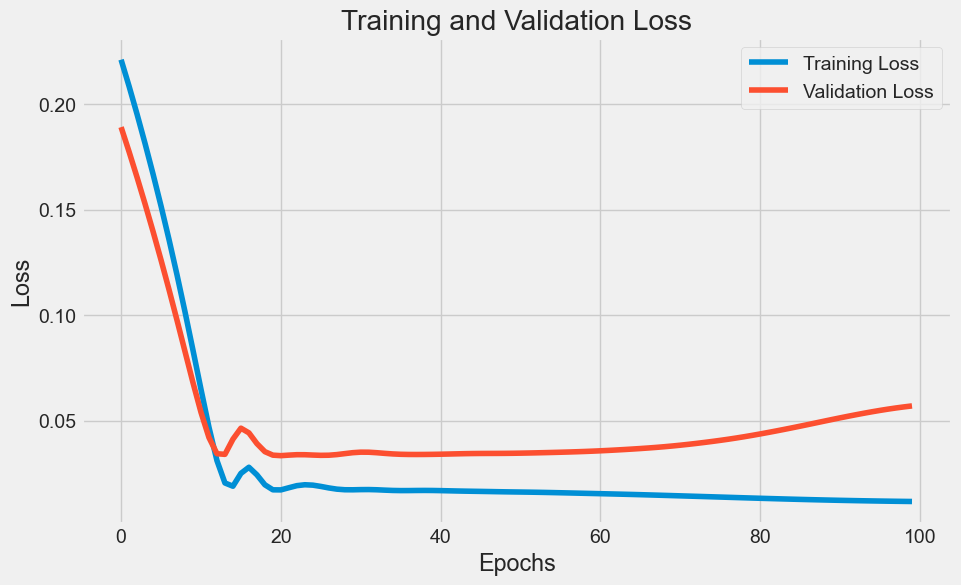

In [20]:
# Visualisasi Training dan Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

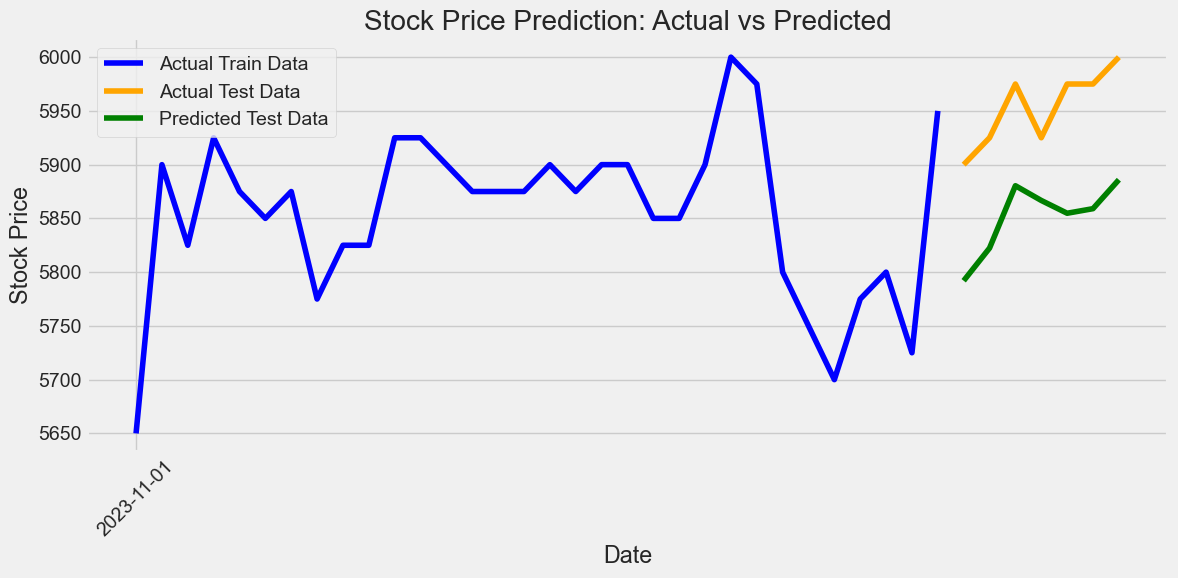

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load dataset
df = pd.read_csv('mandiri_with_sentiment.csv')

# Ambil kolom 'Date' dan 'Close' untuk visualisasi
dates = df['Date'].values
close_prices = df['Close'].values

# Bagi data menjadi train dan test
train_size = int(len(df) * 0.8)
train_dates = dates[:train_size]
train_close_prices = close_prices[:train_size]
test_dates = dates[train_size:]
test_close_prices = close_prices[train_size:]
test_dates = test_dates[:len(predicted_inversed)]  # Sesuaikan panjang data test dengan prediksi
test_close_prices = test_close_prices[:len(predicted_inversed)]  # Sesuaikan panjang data test dengan prediksi

# Asumsikan predicted_inversed telah dihitung dan dipulihkan dari skala (inversed)
# Prediksi pada data testing
predicted_close_prices = predicted_inversed  # Sesuaikan dengan variabel prediksi Anda

# Gabungkan tanggal dan harga dari data training dan testing
all_dates = np.concatenate((train_dates, test_dates))
all_close_prices = np.concatenate((train_close_prices, test_close_prices))

# Plot hasil prediksi vs data asli untuk training dan testing
plt.figure(figsize=(12, 6))

# Plot data training
plt.plot(train_dates, train_close_prices, label='Actual Train Data', color='blue')

# Plot data testing
plt.plot(test_dates, test_close_prices, label='Actual Test Data', color='orange')

# Plot prediksi pada data testing
plt.plot(test_dates, predicted_close_prices, label='Predicted Test Data', color='green')

plt.title('Stock Price Prediction: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.xticks(all_dates[::100], rotation=45)  # Menampilkan setiap 10 tanggal agar lebih rapi
plt.legend()
plt.tight_layout()  # Untuk menghindari label tanggal terpotong
plt.show()


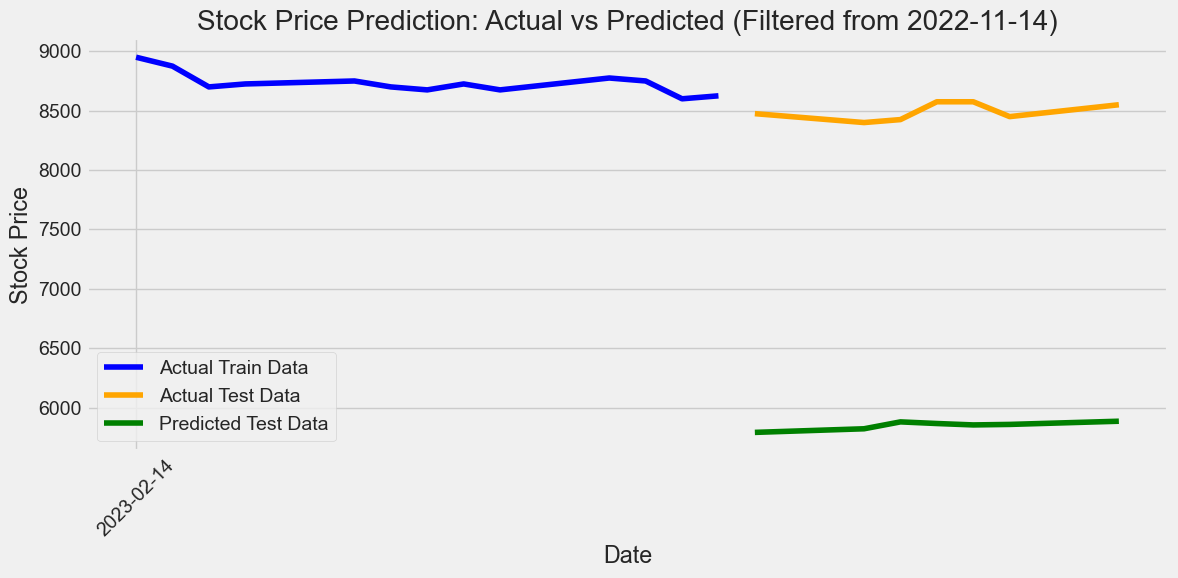

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load dataset
df = pd.read_csv('bca_with_sentiment3.csv')

# Konversi kolom 'Date' menjadi datetime
df['Date'] = pd.to_datetime(df['Date'])

# Ambil kolom 'Date' dan 'Close' untuk visualisasi
dates = df['Date'].values
close_prices = df['Close'].values

# Bagi data menjadi train dan test
train_size = int(len(df) * 0.8)
train_dates = dates[:train_size]
train_close_prices = close_prices[:train_size]
test_dates = dates[train_size:]
test_close_prices = close_prices[train_size:]
test_dates = test_dates[:len(predicted_inversed)]  # Sesuaikan panjang data test dengan prediksi
test_close_prices = test_close_prices[:len(predicted_inversed)]  # Sesuaikan panjang data test dengan prediksi

# Asumsikan predicted_inversed telah dihitung dan dipulihkan dari skala (inversed)
# Prediksi pada data testing
predicted_close_prices = predicted_inversed  # Sesuaikan dengan variabel prediksi Anda

# Gabungkan tanggal dan harga dari data training dan testing
all_dates = np.concatenate((train_dates, test_dates))
all_close_prices = np.concatenate((train_close_prices, test_close_prices))

# Filter data mulai dari tanggal 2022-11-14
start_date = np.datetime64('2023-02-14')
mask = all_dates >= start_date
filtered_dates = all_dates[mask]
filtered_train_close_prices = train_close_prices[len(train_close_prices) - np.sum(mask[:train_size]):]
filtered_test_close_prices = test_close_prices[:np.sum(mask[train_size:])]
filtered_predicted_close_prices = predicted_close_prices[:np.sum(mask[train_size:])]

# Plot hasil prediksi vs data asli untuk training dan testing
plt.figure(figsize=(12, 6))

# Plot data training
plt.plot(filtered_dates[:len(filtered_train_close_prices)], filtered_train_close_prices, label='Actual Train Data', color='blue')

# Plot data testing
plt.plot(filtered_dates[len(filtered_train_close_prices):], filtered_test_close_prices, label='Actual Test Data', color='orange')

# Plot prediksi pada data testing
plt.plot(filtered_dates[len(filtered_train_close_prices):], filtered_predicted_close_prices, label='Predicted Test Data', color='green')

plt.title('Stock Price Prediction: Actual vs Predicted (Filtered from 2022-11-14)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.xticks(filtered_dates[::20], rotation=45)  # Menampilkan setiap 5 tanggal agar lebih rapi
plt.legend()
plt.tight_layout()  # Untuk menghindari label tanggal terpotong
plt.show()

In [23]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

# Asumsikan kolom 'Date' ada di dataset asli
# Bagi tanggal ke dalam train dan test set secara sinkron dengan data lainnya
dates = data['Date'][look_back:]  # Perhatikan bahwa kita hanya mengambil tanggal setelah look_back

dates_train, dates_test = train_test_split(dates, test_size=0.2, random_state=42)

# Buat DataFrame untuk hasil prediksi
results = pd.DataFrame({
    'Date': dates_test.values,
    'Actual': y_test_inversed,
    'Predicted': predicted_inversed
})

# Format tanggal untuk memastikan konsistensi
results['Date'] = pd.to_datetime(results['Date'])
results = results.sort_values(by='Date')

# Tampilkan hasil prediksi dan nilai asli
print(results.head())

# Simpan hasil ke file CSV jika diperlukan
results.to_csv('predictions_vs_actuals.csv', index=False)

# Jika ingin membuat visualisasi
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(results['Date'], results['Actual'], label='Actual Prices', color='blue', alpha=0.7)
plt.plot(results['Date'], results['Predicted'], label='Predicted Prices', color='orange', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Stock Prices')
plt.legend()
plt.grid()
plt.show()

ValueError: All arrays must be of the same length

In [ ]:
from datetime import timedelta

# Function to forecast future stock prices
def forecast_future_with_dates(model, last_sequence, steps_ahead=10):
    forecast = []
    current_sequence = last_sequence
    for _ in range(steps_ahead):
        predicted_value = model.predict([current_sequence[:, :, :len(technical_features)], current_sequence[:, :, len(technical_features):len(technical_features) + len(fundamental_features)], current_sequence[:, :, len(technical_features) + len(fundamental_features):]])
        forecast.append(predicted_value[0, 0])
        new_sequence = np.roll(current_sequence, -1, axis=1)
        new_sequence[0, -1] = predicted_value
        current_sequence = new_sequence
    return np.array(forecast)

# Get the last sequence from the test set and concatenate them correctly
last_sequence_technical = X_test_technical[-1]
last_sequence_fundamental = X_test_fundamental[-1]
last_sequence_sentiment = X_test_sentiment[-1]

# Combine all features into one sequence
last_sequence = np.concatenate([last_sequence_technical, last_sequence_fundamental, last_sequence_sentiment], axis=1).reshape(1, look_back, -1)

# Forecast future prices
future_predictions = forecast_future_with_dates(model, last_sequence, steps_ahead=10)

# Inverse transform predictions
future_predictions_inversed = scaler_technical.inverse_transform(np.hstack((future_predictions.reshape(-1, 1), np.zeros((len(future_predictions), len(technical_features) - 1)))))[:, 0]

# Generate dates for future predictions
last_date = pd.to_datetime(df['Date'].iloc[-1])
future_dates = [last_date + timedelta(days=i) for i in range(1, 11)]

# Display predictions with dates
predictions_with_dates = pd.DataFrame({
    'Date': future_dates,
    'Predicted Close Price': future_predictions_inversed
})

print("Prediksi harga saham 10 hari ke depan:")
print(predictions_with_dates)

In [ ]:
# # Get the stock quote
# # df = yf.download('TLKM.JK', start='2021-01-01', end=datetime.now())
# company = 'TLKM.JK'
# df = yf.download(company, start='2024-01-01', end='2024-10-10')
# # df = yf.download(company, start='2020-01-01', end='2023-12-29')
# # Show the data
# df = df.drop(columns=['Adj Close'])
# df.tail(10)
# # print(df.tail(10)['Close'])

In [24]:
import pandas as pd

# Gabungkan data nilai aktual dan prediksi beserta tanggal ke dalam DataFrame
data_comparison = pd.DataFrame({
    'Date': data['Date'].iloc[len(data) - len(y_test_inversed):].values,  # Ambil tanggal sesuai indeks y_test
    'Actual': y_test_inversed,
    'Predicted': predicted_inversed
})

# Simpan DataFrame ke dalam file CSV
data_comparison.to_csv('predicted_vs_actual_with_date.csv', index=False)

print("File 'predicted_vs_actual_with_date.csv' berhasil dibuat dan disimpan.")

File 'predicted_vs_actual_with_date.csv' berhasil dibuat dan disimpan.


In [ ]:
import matplotlib.pyplot as plt

# Pastikan kolom 'Date' sudah menjadi datetime
# dan memiliki jumlah yang sesuai dengan y_test dan predicted
dates = data['Date'][train_size:train_size + len(y_test)]

# Plot hasil prediksi vs data asli untuk testing
plt.figure(figsize=(12, 6))
plt.plot(dates, y_test_inversed, label='Actual Test Data')
plt.plot(dates, predicted_inversed, label='Predicted Test Data')
plt.title('Testing Data LSTM: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()